Deep Learning
=============

Assignment 1
------------

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [1]:
!../bin/prepare-data

File already exists: data/compressed/notMNIST_large.tar.gz
md5sum: 70a95b805ecfb6592c48e196df7c1499  data/compressed/notMNIST_large.tar.gz
File already exists: data/compressed/notMNIST_small.tar.gz
md5sum: c9890a473a9769fda4bdf314aaf500dd  data/compressed/notMNIST_small.tar.gz
Extract already exists: data/raw/train
Extract already exists: data/raw/test
Done.


In [2]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
import matplotlib.pyplot as plt
import numpy as np
import itertools
import os
import sys
import pandas as pd
from IPython.display import display, Image


# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

%run "../lib/io.py"

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labeled examples. Given these sizes, it should be possible to train models quickly on any machine.

Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labeled A through J.

---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

In [3]:
data_dir="../data/raw/train/A/"
files = os.listdir(data_dir)
for f in itertools.islice(files, 5):
    image_path = os.path.join(data_dir, f)
    display(Image(image_path))

Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

A few images might not be readable, we'll just skip them.

Could not read: ../data/raw/train/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png - it's ok, skipping.
Could not read: ../data/raw/train/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png - it's ok, skipping.
Could not read: ../data/raw/train/A/Um9tYW5hIEJvbGQucGZi.png - it's ok, skipping.
Full dataset tensor: (52909, 28, 28)
Mean: -0.128250162073
Standard deviation: 0.443120638191


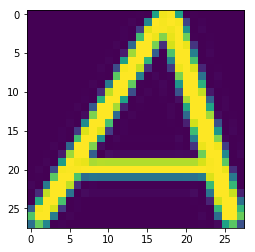

In [4]:
dataset = load_letter("../data/raw/train/A/")

print('Full dataset tensor:', dataset.shape)
print('Mean:', np.mean(dataset))
print('Standard deviation:', np.std(dataset))
plt.imshow(dataset[0])

Let's pickle all the letters in order to speed up work with them in future.
And let's verify that the data still looks good. 

Could not read: ../data/raw/train/D/VHJhbnNpdCBCb2xkLnR0Zg==.png - it's ok, skipping.
Could not read: ../data/raw/train/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png - it's ok, skipping.
Could not read: ../data/raw/train/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png - it's ok, skipping.
Could not read: ../data/raw/train/A/Um9tYW5hIEJvbGQucGZi.png - it's ok, skipping.
Could not read: ../data/raw/train/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png - it's ok, skipping.
Could not read: ../data/raw/test/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png - it's ok, skipping.
Could not read: ../data/raw/test/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png - it's ok, skipping.


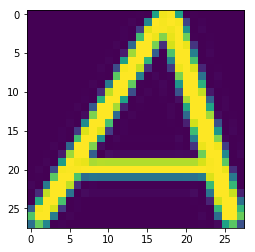

In [9]:
pickle_letters("../data/raw/train", "../data/pickle/train")
pickle_letters("../data/raw/test", "../data/pickle/test")

with open("../data/pickle/train/A.pickle", 'rb') as f:
    dataset = pickle.load(f)
plt.imshow(dataset[0])

---
Problem 3
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

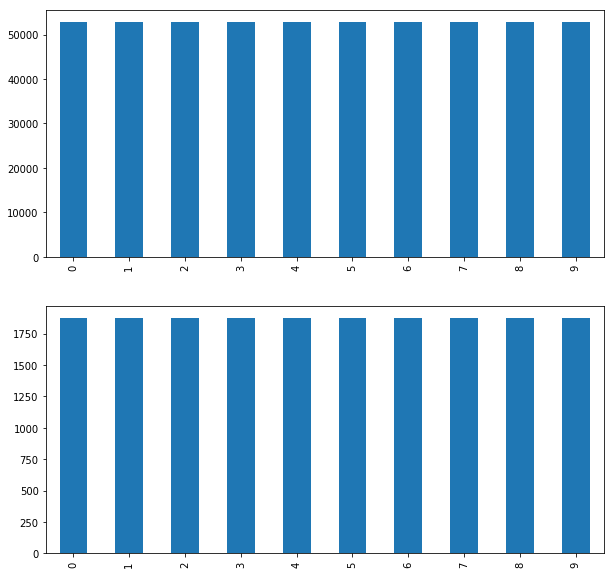

In [5]:
def letters_stats(src_dir):
    return pd.Series([l.shape[0] for l in unpickle_letters(src_dir) ])

fig, axes = plt.subplots(nrows=2, ncols=1)
letters_stats("../data/pickle/train").plot(kind="bar", ax=axes[0], figsize=(10, 10))
letters_stats("../data/pickle/test").plot(kind="bar", ax=axes[1], figsize=(10, 10))

Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.
Also create a validation dataset for hyperparameter tuning.
And we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

`build_dataset` does split and shuffeling.

In [2]:
train_size = 200000
valid_size = 10000
test_size = 10000

train, valid = build_datasets("../data/pickle/train", train_size, valid_size)
test, _ = build_datasets("../data/pickle/test", test_size, 0)

---
Problem 4
---------
Convince yourself that the data is still good after shuffling!

---

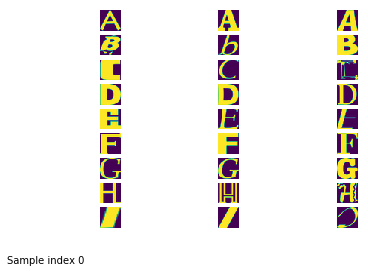

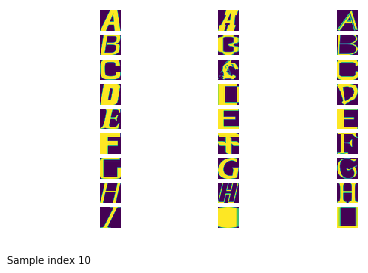

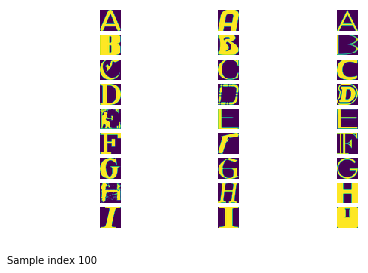

In [3]:
def show_letters(dataset, ax, column=None, sample_index=None):
    for label in range(9):   
     letters = dataset.x[dataset.y == label]
     ax[label, column].axis("off")
     ax[label, column].imshow(letters[sample_index])

for sample_index in [0, 10, 100]:
    fig, ax = plt.subplots(nrows=9, ncols=3)
    fig.text(x=0, y=0, s="Sample index {}".format(sample_index))
    show_letters(train,ax, column=0, sample_index=sample_index)
    show_letters(valid,ax, column=1, sample_index=sample_index)
    show_letters(test,ax, column=2, sample_index=sample_index)

Finally, let's save the data for later reuse:

In [4]:
pickle_file = "../data/pickle/workset.pickle"
pickle_workset(pickle_file, Workset(train, valid, test))
print('Compressed pickle size:', os.stat(pickle_file).st_size)

Compressed pickle size: 1381600477


---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---

In [3]:
%run "../lib/1_notmnist/model.py"
workset =  unpickle_workset("../data/pickle/workset.pickle")

In [15]:
%run "../lib/1_notmnist/model.py"
m1 = model1()
m2 = model2()

In [16]:
m1.fit(workset.train.x, workset.train.y)
print("Train score: ", m1.score(workset.train.x, workset.train.y))
print("Valid score: ", m1.score(workset.valid.x, workset.valid.y))
print("Test score: ",  m1.score(workset.test.x, workset.test.y))

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   22.8s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


Train score:  0.997545
Valid score:  0.8823
Test score:  0.9422


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


In [17]:
m2.fit(workset.train.x, workset.train.y)
print("Train score: ", m2.score(workset.train.x, workset.train.y))
print("Valid score: ", m2.score(workset.valid.x, workset.valid.y))
print("Test score: ",  m2.score(workset.test.x, workset.test.y))

[LibLinear]Train score:  0.830905
Valid score:  0.8233
Test score:  0.8915
